In [1]:
import os
import json
import time
import gzip
import bcolz
import numpy as np
import re
import copy
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pickle
import random
import json
import inspect
from spacy.lang.en import English

In [2]:
# variables
# seed = 1337
# pickleFile = '../Datasets/Reviews/dataset.pkl'
# gloveDimension = 50
# glovePath = "/media/data/Datasets/glove"
# dataset_reduction = 16
# trainPortion = 0.80
# vocabularyLimit = 30000
# cutoff = 60
# datasetFile = '../Datasets/Reviews/dataset_ready.pkl'
# example_item_id = 19

# params = {
#     "seed" : 1337,
#     "pickleFile" :  '../Datasets/Reviews/dataset.pkl',
#     "gloveDimension" : 50,
#     "glovePath" : "/media/data/Datasets/glove",
#     "datasetReduction" : 16,
#     "trainPortion" : 0.80,
#     "vocabularyLimit" : 30000,
#     "cutoff" : 60,
#     "datasetFile" : '../Datasets/Reviews/dataset_ready.pkl',
#     "example_item_id" : 19, 
#     "saveDataset" : False
# }

params = {
    "seed" : 1337,
    "pickleFile" :  '../Datasets/Reviews/dataset.pkl',
    "gloveDimension" : 50,
    "glovePath" : "/media/data/Datasets/glove",
    "datasetReduction" : 16,
    "trainPortion" : 0.80,
    "vocabularyLimit" : 30000,
    "cutoff" : 60,
    "datasetFile" : '../Datasets/Reviews/dataset_ready.pkl',
    "example_item_id" : 19, 
    "saveDataset" : True
}

In [3]:
random.seed(params['seed'])
np.random.seed(params['seed'])

nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)
tokenizer = nlp.create_pipe("tokenizer")

## Loading the Dataset

In [4]:
start = time.clock()
dataset = pickle.load( open( params['pickleFile'], "rb" ))
duration = time.clock() - start
print("Loaded the dataset in", round(duration,2), "seconds.")

Loaded the dataset in 6.91 seconds.


In [5]:
print("There are",len(dataset), "amazon items.")

There are 63001 amazon items.


## Loading Glove Words

In [6]:
def loadGlove(glove_path, dim=50):
    acceptedDimensions = [50, 100, 200, 300]
    if dim not in acceptedDimensions:
        print("You didn't choose a right dimension.")
        print("Try one of these:", acceptedDimensions)
        return None
    pickleWordFile = f'{glove_path}/6B.'+str(dim)+'_words.pkl'
    pickleIdFile   = f'{glove_path}/6B.'+str(dim)+'_idx.pkl'
    pickleDatFile  = f'{glove_path}/glove.6B.'+str(dim)+'.dat'
    pickleDataset  = f'{glove_path}/glove.6B.'+str(dim)+'d.txt'
    
    if os.path.isfile(pickleWordFile):
        # check if we've made the outputs before
        print("Preloading files..", end=" ")
        vectors = bcolz.open(pickleDatFile)[:]
        words = pickle.load(open(pickleWordFile, 'rb'))
        word2idx = pickle.load(open(pickleIdFile, 'rb'))
        glove = {w: vectors[word2idx[w]] for w in words}
        print("Done.")
        return glove
    else:
        print("Doesn't work.", end=" ")

glove = loadGlove(params['glovePath'], dim=params['gloveDimension'])
gloveWords = glove.keys()

Preloading files.. Done.


In [7]:
print("Glove Vocabulary Size:",len(gloveWords))

Glove Vocabulary Size: 400000


## Preprocessing Data

In [8]:
def preprocess(paragraph):
    # split paragraph by full stops
    paragraph = paragraph.lower()
    paragraph = re.sub("([,!?()-+&£$.%*'])", r' \1 ', paragraph)
    paragraph = re.sub('\s{2,}', ' ', paragraph)
    paragraph = paragraph.split(" ")
    # remove empty string
    return paragraph
    
def discretise(value, word):
    return word + "_" + str(value)

In [9]:
def handleItem(itemID, dataset=dataset, printDebug=False):
    """
    Filters words out based on whether they're in the GloVe dataset or not.
    
    Parameters:
    
    """

    reviews = []
    for i in range(len(dataset[itemID])):
        # initialise variables
        entry = dataset[itemID][i]
        reviewerID = entry['reviewerID']
        
        if len(entry['reviewText']) < 1:
            continue

        """
        Review Text Processing
        """
        

        # spacy method
        sentences = [[str(i).lower() for i in tokenizer(str(sentence))] for sentence in nlp(entry['reviewText']).sents]
        
        # preprocess summary
        summary = [str(i).lower() for i in tokenizer(entry['summary'])]
        
        # merge summary sequence and review sequences together into overall entries.
#         if len(sentences) < 2:
#             entries =  [["<sos>", "<summary>"] + summary + ["</summary>"]] + [["<sos>", "<text>"] + sentences[0] + ["</text>", "<eor>", "<eos>"]]
#         else:
#             subset = [["<sos>", "<text>"] + x + ["</text>"] for x in sentences[:-1]]
#             entries =  [["<sos>", "<summary>"] + summary + ["</summary>"]] + subset + [["<sos>", "<text>"] + sentences[-1] + ["</text>", "<eor>", "<eos>"]]
        
        entries = [summary] + sentences
        entries = [x + ["<eos>"] for x in entries]
  
        # setup review parameters
        rating   = [discretise(entry['overall'], "rating")]

        # compute polarity
        good, bad = entry['helpful'][0], entry['helpful'][1]
        
        try:
            polarity = (good - bad) / (good + bad)
        except ZeroDivisionError:
            polarity = 0
        polarity = np.tanh(polarity)
        polarity = np.round(polarity, 1)
        polarity = [discretise(polarity, "polarity")]

        # create identity/conditioning entry
        identifier = itemID.lower()
        identity = [l for l in identifier] + rating + polarity

        # add conditionining entry to each entry
        formatted = [entry for entry in entries]

        if printDebug:
            print("ENTRY:",dataset[itemID][i])
            print("IDENTITY:",identity)

        for i in range(len(formatted)-1):
            # add the conditioning variable to the input. the output value does not have the conditioning variable.
            reviews.append([identity + formatted[i], formatted[i+1]])
            if printDebug:
                print(reviews[-1][0], "->", reviews[-1][1])
        if printDebug:
            break
            
    return reviews

In [10]:
datasetKeys = list(dataset.keys())
example_set = handleItem(datasetKeys[params['example_item_id']],printDebug=True)

ENTRY: {'reviewerID': 'AA8JH8LD2H4P9', 'asin': '7214047977', 'reviewerName': 'Claudia J. Frier', 'helpful': [3, 4], 'reviewText': 'This fits my 7" kindle fire hd perfectly! I love it. It even has a slot for a stylus. The kindle is velcroed in so it\'s nice and secure. Very glad I bought this!', 'overall': 5.0, 'summary': 'love it', 'unixReviewTime': 1354665600, 'reviewTime': '12 5, 2012'}
IDENTITY: ['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', 'love', 'it', '<eos>'] -> ['this', 'fits', 'my', '7', '"', 'kindle', 'fire', 'hd', 'perfectly', '!', '<eos>']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', 'this', 'fits', 'my', '7', '"', 'kindle', 'fire', 'hd', 'perfectly', '!', '<eos>'] -> ['i', 'love', 'it', '.', '<eos>']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', 'i', 'love', 'it', '.', '<eos>'] -> ['it

In [11]:

identity = example_set[0][0][:example_set[0][0].index("<eos>")]

example_tag = {"reference":dataset[datasetKeys[params['example_item_id']]][0],
               "result":example_set}
# print(json.dumps(example_tag, indent=2, sort_keys=True))

In [12]:
print(len(datasetKeys))

63001


In [13]:
def processItems(func, args, n_processes = 7):
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in enumerate(p.imap_unordered(func, args)):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

In [14]:
reviews = processItems(handleItem,datasetKeys[::params['datasetReduction']])

100%|██████████| 3938/3938 [00:47<00:00, 83.15it/s]


In [15]:
datasetSize = len(reviews)
trainRatio = int(datasetSize * params['trainPortion'])

train = reviews[:trainRatio]
validation = reviews[trainRatio:]

print("Num Reviews:")
print("Training:", len(train), "\t\tValidation:",len(validation))

# now we need to flatten train and validation.
trainents = []
for review in train:
    trainents += [entry for entry in review]
valents = []
for review in validation:
    valents += [entry for entry in review]
    
train = trainents
validation = valents

print("Sequences:")
print("Training:",len(train),"\tValidation:",len(validation))

Num Reviews:
Training: 3150 		Validation: 788
Sequences:
Training: 574362 	Validation: 153211


In [16]:
# get the number of itemIDs
for row in train:
    print(row)
    break

[['b', '0', '0', '0', '0', '0', 'j', '1', 'u', 'b', 'rating_5.0', 'polarity_0.0', 'kb', 'at', 'to', 'ps/2', 'adapter', '<eos>'], ['the', 'package', 'arrived', 'in', 'a', 'timely', 'fashion', 'and', 'in', 'good', 'shape', '.', '<eos>']]


## Getting ID's of words

To improve the throughput of the model, we should reduce the embedding size. Here we'll look at all the words and keep track ones that exist. We'll make a reduced word2id based on this set.

In [17]:
wordcounts = {}

In [18]:
# here we reduce the size of the dataset so we can debug our model.
print("Subsetting Reviews..")
print("We now have", len(train), "reviews.")

Subsetting Reviews..
We now have 574362 reviews.


In [19]:
# get word frequency for words in training data
for row in tqdm(train):
    for sequences in row:
        for word in sequences:
            word = str(word)
            # setup container if word does not exist
            if word not in wordcounts:
                wordcounts[word] = 0
            # increment
            wordcounts[word] += 1

100%|██████████| 574362/574362 [00:09<00:00, 61306.76it/s]


In [20]:
# get words that are not in the glove dataset
knowns   = [word for word in wordcounts if word in glove]
unknowns = [word for word in wordcounts if word not in glove]
# sort words by their frequency
wordOrder = list(sorted(knowns, key=lambda x: wordcounts[x], reverse=True))

In [21]:
print(len(knowns), len(unknowns))

41822 84686


In [22]:
# threshold number of tokens based on the vocabulary limit.
wordOrder = wordOrder[:params['vocabularyLimit']]

In [23]:
# store glove vectors for each token
weights = [glove[word] for word in wordOrder]

In [24]:
# create vectors for rating and polarity
for word in unknowns:
    if ("rating" in word) or ("polarity" in word):
        try:
            part = word.split("_")
            if part[1] == "-0.0":
                part[1] = "0.0"
            weight = glove[part[0]] + glove[part[1]]
            wordOrder.append(word)
            weights.append(weight)
        except:
            pass

In [25]:
# create dictionaries for constant time referencing
id2word = {idx: w for (idx, w) in enumerate(wordOrder)}
word2id = {w: idx for (idx, w) in enumerate(wordOrder)}

In [26]:
lim = len(word2id)

# add <sos> (start of sequence)
weights.append(glove['sos'])
word2id['<sos>'] = lim
id2word[lim] = ['<sos>']
lim += 1

# add <eos> (end of sequence)
weights.append(glove['eos'])
word2id['<eos>'] = lim
id2word[lim] = '<eos>'
lim += 1


gloveDimension = params['gloveDimension']

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<summary>'] = lim
id2word[lim] = '<summary>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['</summary>'] = lim
id2word[lim] = '</summary>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<text>'] = lim
id2word[lim] = '<text>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['</text>'] = lim
id2word[lim] = '</text>'
lim += 1


# add <unk> (unknown token)
weights.append(glove['unk'])
word2id['<unk>'] = lim
id2word[lim] = '<unk>'

# add <pad> 
id2word[len(word2id)] = "<pad>"
word2id["<pad>"] = len(word2id)
weights.append(np.random.normal(0,0,gloveDimension))

In [27]:
# create functions that incorporate dictionary search
# and returns <unk> token upon failure
def wordToID(word,corp=word2id):
    if word in corp:
        return corp[word]
    return corp['<unk>']

def IDToWord(id,corp=id2word, ref=word2id):
    if id in corp:
        return corp[id]
    return corp[ref['<unk>']]

In [28]:
# convert words to their id's in the review.
def entriesToWordIDs(group):
    return [[[wordToID(word) for word in seq] for seq in row] for row in tqdm(group)]
    
train = entriesToWordIDs(train)
validation = entriesToWordIDs(validation)

100%|██████████| 153211/153211 [00:01<00:00, 107271.90it/s]


In [29]:
sizes = {}
for i in range(len(train)):
    row = train[i]
    for seq in row:
        length = len(seq)
        if length not in sizes:
            sizes[length] = []
        sizes[length].append(i)

seqlengths = list(sorted(sizes.keys(), key=lambda x: len(sizes[x]), reverse=True))
print("The longest sequence in our dataset is",max(seqlengths),"tokens long.")

The longest sequence in our dataset is 1442 tokens long.


In [30]:
# print the longest sequence.
" ".join([IDToWord(x) for x in train[sizes[max(seqlengths)][0]][1][1:]])

"lcd 's need native resolution , i 've included below what took me a while to find : <unk> <unk> 256 mb supported video <unk> 0 : <unk> 256 colours ( 8-bit ) <unk> 1 : <unk> 256 colours ( 8-bit ) <unk> 2 : <unk> 64 k <unk> ( 16-bit ) <unk> 3 : <unk> 64 k <unk> ( 16-bit ) <unk> 4 : <unk> <unk> <unk> ( 32-bit ) <unk> 5 : <unk> <unk> <unk> ( 32-bit ) <unk> 6 : 320x240 256 colours ( 8-bit ) <unk> 7 : 320x240 256 colours ( 8-bit ) <unk> 8 : 320x240 64 k <unk> ( 16-bit ) <unk> 9 : 320x240 64 k <unk> ( 16-bit ) <unk> 10 : 320x240 <unk> <unk> ( 32-bit ) <unk> 11 : 320x240 <unk> <unk> ( 32-bit ) <unk> 12 : <unk> 256 colours ( 8-bit ) <unk> 13 : <unk> 256 colours ( 8-bit ) <unk> 14 : <unk> 64 k <unk> ( 16-bit ) <unk> 15 : <unk> 64 k <unk> ( 16-bit ) <unk> 16 : <unk> <unk> <unk> ( 32-bit ) <unk> 17 : <unk> <unk> <unk> ( 32-bit ) <unk> 18 : <unk> 256 colours ( 8-bit ) <unk> 19 : <unk> 64 k <unk> ( 16-bit ) <unk> 20 : <unk> <unk> <unk> ( 32-bit ) <unk> 21 : <unk> 256 colours ( 8-bit ) <unk> 22 : <u

In [31]:
# used for charting purposes
for i in range(1709):
    if i not in sizes:
        sizes[i] = []

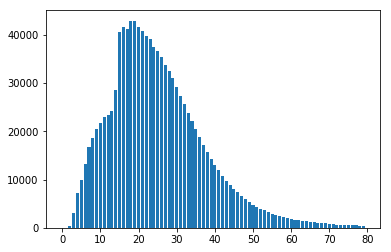

In [32]:
# plot histogram of sequence lengths
ents = [x for x in range(0,80)]
bins = [len(sizes[x]) for x in ents]
plt.bar(ents,bins)
plt.show()

In [33]:
print("Cutoff sequence length:", params['cutoff'])

Cutoff sequence length: 60


In [34]:
def trimSeq(group, cutoff):
    good = []
    for i in tqdm(range(len(group))):
        row = group[i]
        if len(row[0]) <= cutoff and len(row[1]) <= cutoff:
            good.append(i) 
    group = [group[x] for x in good]
    return group

#     return [[seq[:cutoff] for seq in row] for row in tqdm(group)]

print("BEFORE:", len(train), len(validation))
train = trimSeq(train, params['cutoff'])
validation = trimSeq(validation, params['cutoff'])
print("AFTER:", len(train), len(validation))

 91%|█████████ | 520478/574362 [00:00<00:00, 2588701.63it/s]

BEFORE: 574362 153211


100%|██████████| 153211/153211 [00:00<00:00, 2503871.10it/s]

AFTER: 550828 145984


In [35]:
# create container ready for use in dataset
# we do not add padding here as we want to reduce storage size!
container = {
    'id2word' : id2word,
    'word2id' : word2id,
    'train' : train,
    'validation': validation,
    'weights' : np.matrix(weights),
    'cutoff' : params['cutoff']
}

In [36]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

if params['saveDataset']:
    # save the dataset to a pickle file.
    output = open(params['datasetFile'], 'wb')
    pickle.dump(container, output)
    output.close()

    # save dataset preprocessing parameters
    params['example_filtering'] = example_tag
    params['handleItem'] = inspect.getsource(handleItem)
    param_jsonpath = 'dataset_parameters.json'
    with open(param_jsonpath, 'w') as outfile:
        json.dump(params, outfile)

    print("Saved!", convert_bytes(os.stat(params['datasetFile']).st_size))

Saved! 103.8 MB


In [37]:
import torch

In [38]:
# get sequence lengths for train and validation data
trainx = [x[0] for x in train]
trainy = [x[1] for x in train]
valx   = [x[0] for x in validation]
valy   = [x[1] for x in validation]

In [39]:
print(reviews[0][1])
print("---")
for i in range(0,3):
    xtext = np.array([id2word[x] for x in trainx[i]])
    ytext = np.array([id2word[x] for x in trainy[i]])
    print(xtext, ytext)

[['b', '0', '0', '0', '0', '0', 'j', '1', 'u', 'b', 'rating_5.0', 'polarity_0.0', 'the', 'package', 'arrived', 'in', 'a', 'timely', 'fashion', 'and', 'in', 'good', 'shape', '.', '<eos>'], ['the', 'adapter', 'is', 'exactly', 'what', 'i', 'wanted', 'and', 'makes', 'the', 'connection', 'i', 'needed', '.', '<eos>']]
---
['b' '0' '0' '0' '0' '0' 'j' '1' 'u' 'b' 'rating_5.0' 'polarity_0.0' 'kb'
 'at' 'to' 'ps/2' 'adapter' '<eos>'] ['the' 'package' 'arrived' 'in' 'a' 'timely' 'fashion' 'and' 'in' 'good'
 'shape' '.' '<eos>']
['b' '0' '0' '0' '0' '0' 'j' '1' 'u' 'b' 'rating_5.0' 'polarity_0.0' 'the'
 'package' 'arrived' 'in' 'a' 'timely' 'fashion' 'and' 'in' 'good' 'shape'
 '.' '<eos>'] ['the' 'adapter' 'is' 'exactly' 'what' 'i' 'wanted' 'and' 'makes' 'the'
 'connection' 'i' 'needed' '.' '<eos>']
['b' '0' '0' '0' '0' '0' 'j' '1' 'u' 'b' 'rating_4.0' 'polarity_0.0'
 'very' 'necessary' '<eos>'] ['if' 'you' 'want' 'to' 'use' 'your' 'newly' 'purchased' '1984' 'ibm'
 'model' 'm' 'keyboard' 'with' '

In [40]:
from vad_utils import batchData

device = "cpu"
batchsize = 4
trainx_p = batchData(trainx, word2id['<pad>'], device, batchsize, params['cutoff'])
trainy_p = batchData(trainy, word2id['<pad>'], device, batchsize, params['cutoff'])
trainy_r = batchData(trainy, word2id['<pad>'], device, batchsize, params['cutoff'], backwards=True)
valx_p = batchData(valx, word2id['<pad>'], device, batchsize, params['cutoff'])
valy_p = batchData(valy, word2id['<pad>'], device, batchsize, params['cutoff'])

train_p = (trainx_p, trainy_p)
val_p = (valx_p, valy_p)

In [41]:
index = 0
x_row = trainx_p[0][0]
y_row = trainy_p[0][0]
ybrow = trainy_r[0][0]

# print(x_row)


# entries = [torch.argmax(entry, dim=1) for entry in outputs]
text_x  = np.array([[id2word[x.item()] for x in y] for y in x_row])
text_y  = np.array([[id2word[x.item()] for x in y] for y in y_row])
text_r  = np.array([[id2word[x.item()] for x in y] for y in ybrow])
for i in range(batchsize):
    print("X:"," ".join(text_x[i].tolist()))
    print("Y:"," ".join(text_y[i].tolist()))
    print("R:"," ".join(text_r[i].tolist()))
    print("")

X: b 0 0 0 0 0 j 1 u b rating_4.0 polarity_0.0 if you want to use your newly purchased 1984 ibm model m keyboard with a modern computer using a ps/2 interface . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Y: if you want to use your newly purchased 1984 ibm model m keyboard with a modern computer using a ps/2 interface . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
R: <eos> . interface ps/2 a using computer modern a with keyboard m model ibm 1984 purchased newly your use to want you if <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [42]:
import torch.nn.functional as F
import torch.nn as nn

In [43]:
weights = np.matrix(weights)

In [44]:
np.set_printoptions(threshold=10000)

In [45]:
# cbow 

cel = nn.CrossEntropyLoss()
nll = nn.NLLLoss()
# sig =nn.Sigmoid()

for batch in range(len(train_p[0])):
    # load x, y from batch
    entry_x, entry_y = train_p[0][batch], train_p[1][batch]
    
    # sepeate data from sentence lengths
    y_outs, y_seqs = entry_y
    
    # get y_length
    y_len, num_classes, batch_size = len(y_outs[0]), weights.shape[0], y_outs.shape[0]
    
    # iterate through the words in y
    for w in range(y_len):
        # get indexes of future words
        labels = y_outs[:,w:]

        # create onehot output
        actual_cbow = torch.FloatTensor(batch_size, num_classes).zero_()
        actual_cbow.scatter_(1, y_outs[:,w:], 1)
        
        # ones for non-zero, zero for one-hot
        ref_anti_cbow = torch.ones(batch_size, num_classes)
        ref_anti_cbow.scatter_(1, y_outs[:,w:], 0)
        
        # generate some random matrix of the same shape
        guess = torch.rand(batch_size, num_classes) * 2
        guess = -F.log_softmax(sig(guess), dim=1)
        
#         print("BUG:",bug)
        group_loss = guess * ref_anti_cbow
        
        overall_loss = torch.sum(group_loss, dim=1)
        overall_loss = torch.mean(overall_loss)
#         print("OVL", overall_loss)
        
#         rand = torch.rand(batch_size, num_classes)
        
#         label = y_outs[:, w]
#         y_onehot = torch.FloatTensor(batch_size, num_classes).zero_()
#         label = label.unsqueeze(1)
#         y_onehot.scatter_(1,label,1)
        
#         print(y_onehot)
        
#         print(y_onehot, label.reshape(-1))
        
#         lossfunctions = [
#             nn.BCEWithLogitsLoss(), 
#             F.cross_entropy,
#             cel,
#             nll
#         ]
        
#         for losses in lossfunctions:
#             pred = -y_onehot
#             act  = label.reshape(-1)
#             try:
#                 print(losses, losses(y_onehot,act))
#             except:
#                 print("HUH")
#                 print(losses, losses(y_onehot,y_onehot))
#         break
    break

NameError: name 'sig' is not defined

In [ ]:
onehot = torch.tensor([[0, 1, 0],
                       [1, 0, 0],
                       [0, 0, 1]]).float()
# you would have to get the corresponding indices by:

labels = onehot.argmax(1)
print(labels)
# > tensor([1, 0, 2])
# Now you can use this target tensor for your criterion.

criterion = nn.CrossEntropyLoss()
x = torch.randn(3, 3, requires_grad=True)

loss = criterion(x, labels)
print(loss)

In [ ]:
mu_1, mu_2 = np.random.normal(0,1,[20,20]), np.random.normal(0,1,[20,20])
var_1, var_2 =  np.random.normal(0,1,[20,20]), np.random.normal(0,1,[20,20])

mu_1 = torch.tensor(mu_1)
mu_2 = torch.tensor(mu_2)
var_1 = torch.tensor(var_1)
var_2 = torch.tensor(var_2)

In [ ]:




def kl_og(mu_1, mu_2, var_1, var_2):
    left = (var_1 - var_2)
    middle = torch.div(torch.pow(mu_2 - mu_1, 2), torch.exp(var_2)) 
    right = torch.div(torch.exp(var_1), torch.exp(var_2))
    kld = -0.5 * torch.sum(1 + left - middle - right, 1)
    return kld

In [ ]:
kl_og(mu_1, mu_2, var_1, var_2)

In [ ]:
def kl(mu_1, mu_2, var_1, var_2):
    left = torch.log(torch.sum(var_2)/torch.sum(var_1))
    print("FAM",torch.sum(var_2)/torch.sum(var_1))
    middle =  - 1 + torch.trace(torch.mm(var_2.inverse(), var_1))
    right = (mu_2 - mu_1).transpose(0,1).mm(var_2.inverse()).mm(mu_2 - mu_1)
    kl = 0.5 * (left + middle + right)
    print(left)
    print(middle)
    print(right)
    
kl(mu_1, mu_2, var_1, var_2)